**Не понимаю почему, но подбор признаков с помощью PolynomialFeatures работает так, как я от него ожидаю, только через раз. Я и без него, конечно, графиками и логикой выявляю coef, total score и application, но пытаюсь повторить то, что делали в лекции, и получаю каждый раз разные признаки из PolynomialFeatures, причем нужные - редко. Хотелось бы, чтобы мне, по возможности, объяснили в комментарии к дз**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import uuid
from faker import Faker
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
import warnings  
warnings.filterwarnings('ignore')

Создание данных

In [2]:
n_samples = 300

stud_id = [uuid.uuid4().hex for x in range(n_samples)]
name = [Faker().name() for x in range(n_samples)]
specialty = random.choices(['Mathematics', 'Chemistry', 'Architecture', 'Urbanistics', 'Computer Facilities', 'Power-plant Engineering', 'Mechanical Engineering', 'Biotechnology'], k=n_samples)
admission_year = random.choices([2017, 2018, 2019, 2020], k=n_samples)
coef = random.choices([1, 1.2, 1.5], k=n_samples)
activ_points = random.choices([x for x in range(11)], k=n_samples)
sport_achiev_points = random.choices([0, 5], k=n_samples)
sport_type = [0 for x in range(n_samples)]
edu_points = random.choices([0, 1, 2, 5], k=n_samples)
data = pd.DataFrame({'stud_id': stud_id, 'name': name,'specialty': specialty, 'admission_year': admission_year, 'coef': coef, 'activ_points': activ_points, 'sport_achiev_points': sport_achiev_points, 'sport_type': sport_type, 'edu_points': edu_points})
data['previous_total_points'] = random.choices([x for x in range(25)], k=n_samples)
data['total_points'] =  data[['activ_points', 'sport_achiev_points', 'edu_points']].sum(axis=1)
data['application'] = random.choices([0, 1], weights=[0.2, 0.8], k=n_samples)
data['application_date'] = [0 for x in range(n_samples)]
dates = pd.date_range(datetime.datetime(2021, 3, 1),datetime.datetime(2021, 5, 1)).strftime('%d.%m.%Y').tolist()
applics = np.where(data.application==1)
sports = np.where(data.sport_achiev_points==5)
for x in applics[0]:
    data['application_date'][x] = random.choice(dates)
for x in sports[0]:
    data['sport_type'][x] = random.choice(['Basketball', 'Volleyball', 'Athletics', 'Hockey', 'Tennis', 'Football', 'Gymnastics'])
data['increase'] = data['total_points'] * data['application'] * data['coef'] * 500

In [3]:
data

,stud_id,name,specialty,admission_year,coef,activ_points,sport_achiev_points,sport_type,edu_points,previous_total_points,total_points,application,application_date,increase
0,f5cb0017ab2b496b87ea83c51cb3c581,Tina Jimenez,Mechanical Engineering,2017,1.5,4,5,Basketball,2,21,11,1,01.03.2021,8250.0
1,6587f09693ac454a85434ec9de7bbe20,Shawn Fisher,Power-plant Engineering,2017,1.2,1,5,Gymnastics,1,10,7,1,25.03.2021,4200.0
2,0297984562b54e81b549a6e7fc48f96a,Barry Hardin,Mathematics,2020,1.5,4,5,Volleyball,5,5,14,1,15.03.2021,10500.0
3,e91f99ac2bab4ae890020c10e6a1fb67,Spencer Luna,Chemistry,2019,1.0,5,5,Volleyball,2,0,12,1,02.04.2021,6000.0
4,a5fe93c6509642b6ab4783f10a0ad5bd,Paul Lyons,Urbanistics,2019,1.2,2,5,Tennis,0,22,7,1,20.03.2021,4200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,ac84d9d8a9754db8b365068cb0f643c2,Danielle Lamb,Power-plant Engineering,2017,1.2,6,0,0,5,21,11,1,29.03.2021,6600.0
296,c75f74abfec74ee7a715ba1a67965f48,Kenneth Smith,Mathematics,2020,1.0,4,5,Athletics,0,8,9,1,25.03.2021,4500.0
297,fb3bab7d99d649fa92b06e7e7c8f716b,Karen Turner,Power-plant Engineering,2019,1.5,3,5,Football,2,7,10,1,28.03.2021,7500.0
298,35be32a3253c4a62ae3a6a7100709c13,Curtis Jackson,Power-plant Engineering,2020,1.5,5,5,Tennis,2,2,12,0,0,0.0


Разбор данных

In [4]:
data.describe()

,admission_year,coef,activ_points,sport_achiev_points,edu_points,previous_total_points,total_points,application,increase
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2018.376667,1.233667,4.913333,2.516667,1.870000,11.700000,9.300000,0.810000,4605.833333
std,1.142720,0.199414,3.166372,2.504121,1.810347,7.154529,4.560628,0.392956,3503.596953
min,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,1.000000,2.000000,0.000000,0.000000,5.750000,6.000000,1.000000,1200.000000
50%,2018.000000,1.200000,5.000000,5.000000,1.000000,12.000000,9.000000,1.000000,4650.000000
75%,2019.000000,1.500000,8.000000,5.000000,2.000000,17.250000,13.000000,1.000000,7200.000000
max,2020.000000,1.500000,10.000000,5.000000,5.000000,24.000000,20.000000,1.000000,15000.000000


In [5]:
data['application_date'].unique()

array(['01.03.2021', '25.03.2021', '15.03.2021', '02.04.2021',
       '20.03.2021', '06.04.2021', '26.04.2021', '20.04.2021',
       '07.03.2021', '28.03.2021', 0, '01.05.2021', '14.04.2021',
       '18.04.2021', '11.03.2021', '04.03.2021', '17.03.2021',
       '31.03.2021', '18.03.2021', '03.03.2021', '19.03.2021',
       '06.03.2021', '22.04.2021', '08.03.2021', '01.04.2021',
       '25.04.2021', '23.03.2021', '07.04.2021', '04.04.2021',
       '05.04.2021', '27.04.2021', '08.04.2021', '22.03.2021',
       '17.04.2021', '10.03.2021', '15.04.2021', '30.03.2021',
       '10.04.2021', '29.03.2021', '21.04.2021', '30.04.2021',
       '09.04.2021', '26.03.2021', '28.04.2021', '24.03.2021',
       '19.04.2021', '11.04.2021', '21.03.2021', '16.03.2021',
       '02.03.2021', '03.04.2021', '13.04.2021', '12.04.2021',
       '12.03.2021', '13.03.2021', '05.03.2021', '27.03.2021',
       '16.04.2021', '24.04.2021', '29.04.2021', '23.04.2021'],
      dtype=object)

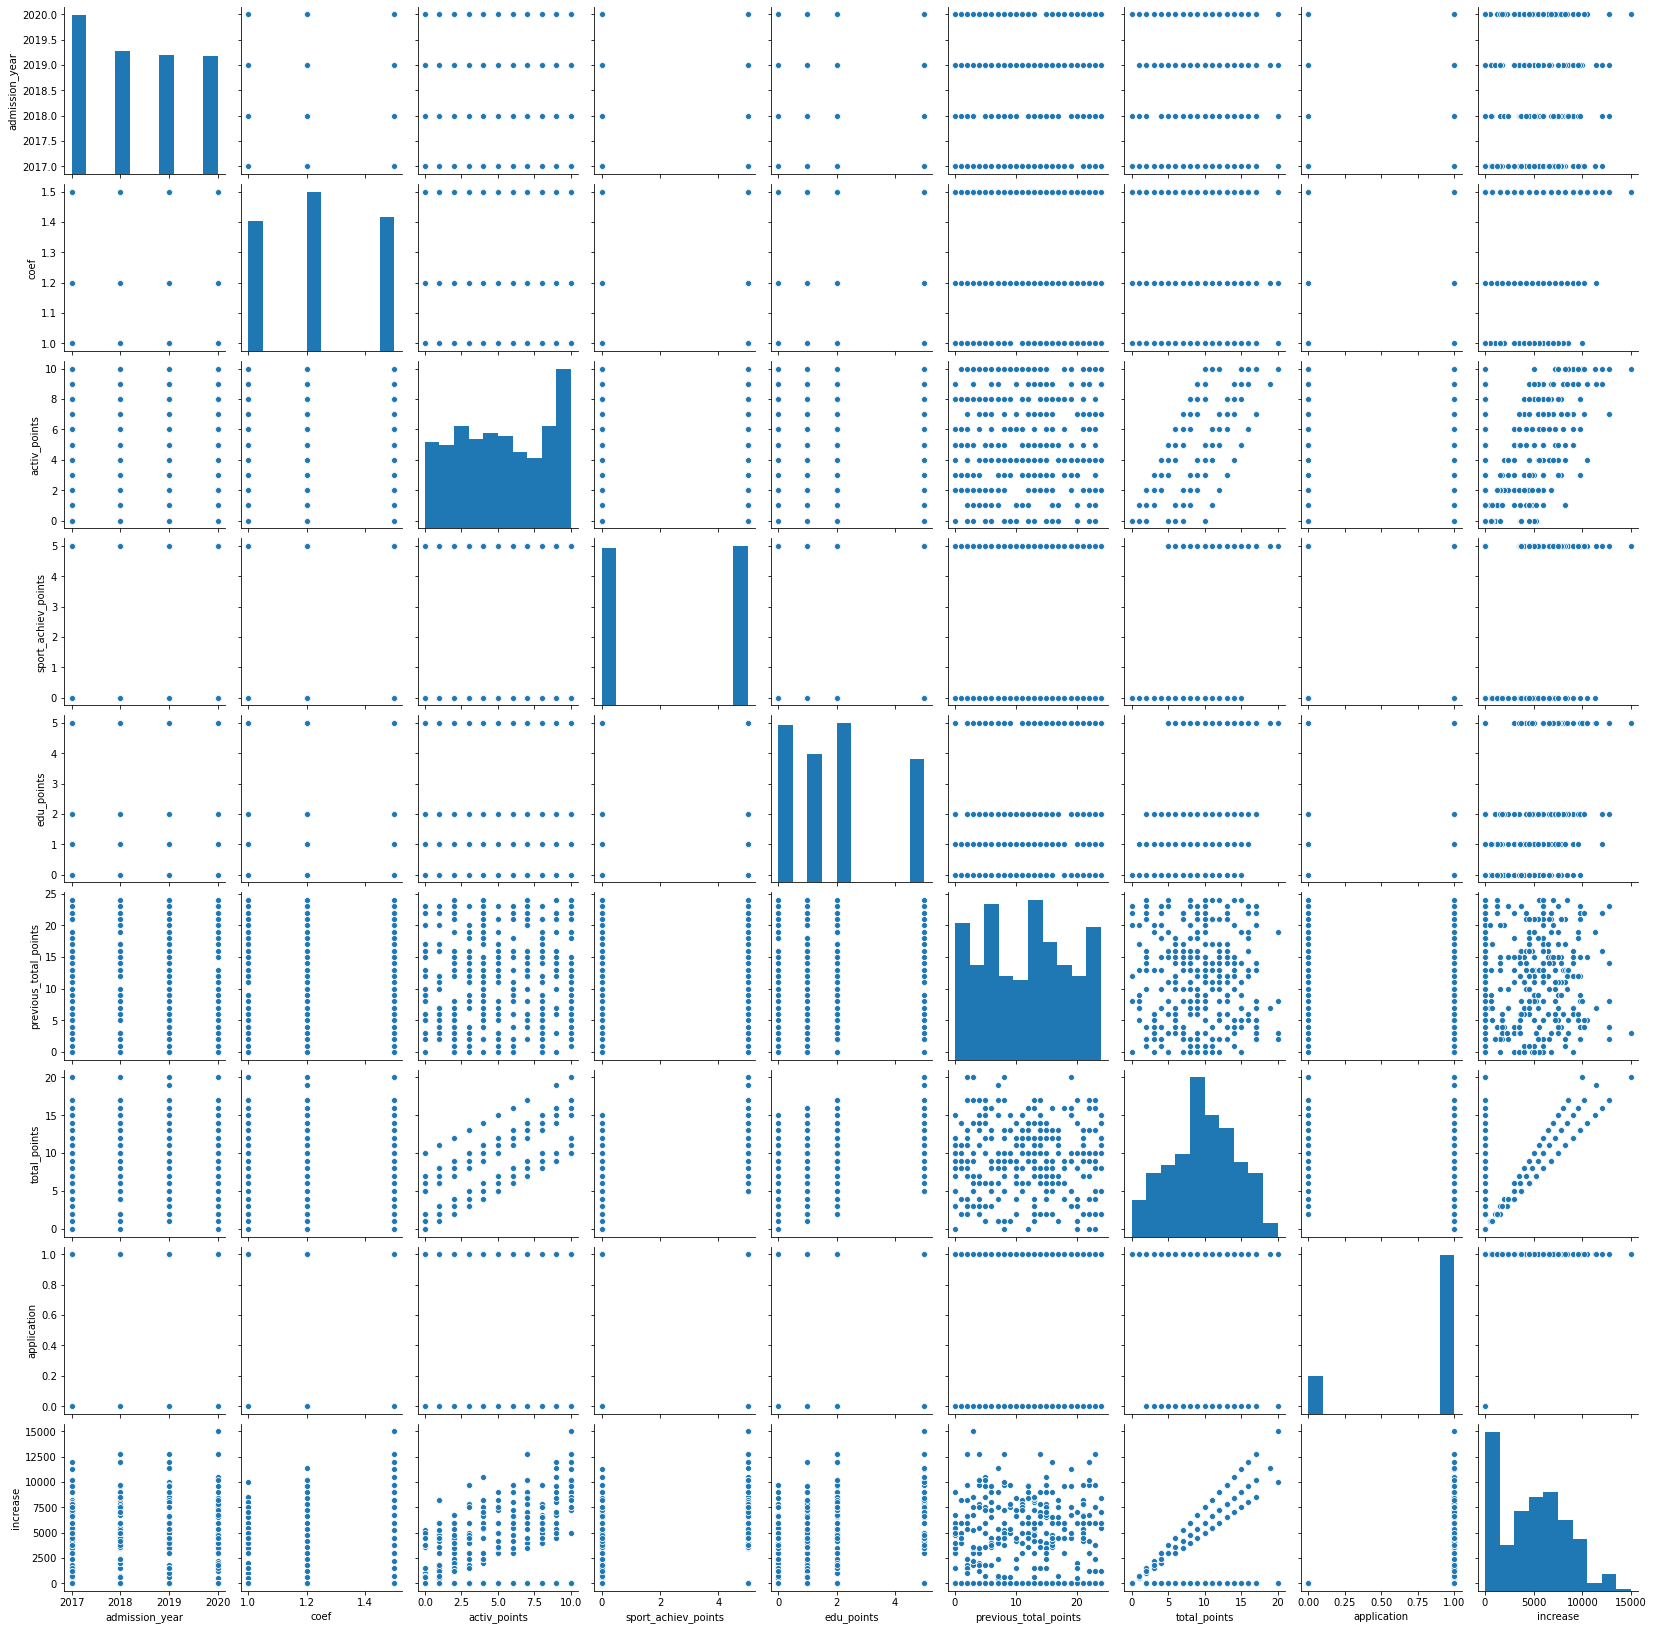

In [6]:
sns.pairplot(data)

*Пропущенных значений нет, заметных в числовых признаках аномалий тоже нет*

*Столбцы stud_id и name уникальны и не повлияют на таргет increase, в модели их можно будет опустить*

*specialty - категориальный признак, будет заменен на ряд столбцов-индикаторов*

*admission_year - категориальный признак представленный числами*

*coef - некий коэффициент, скорее всего, относящийся к баллам, тоже можно посчитать категорией, но тоже представлен числами*

*activ_points (ряд целочисленных значений от 1 до 10) и sport_achiev_points (0/5), а также edu_points (0/1/2/5) суммируются в total_points, который, судя по графику, коррелирует с increase*

*previous_total_points имеет похожие значения на total_points, но в отличие от них не имеют зависимости с increase*

*application - бинарный, означает, была ли подана ли заявка, умножение некоторых других признаков на этот столбец очевидно даст значение таргета*

*application_date - уточняет дату поданной заявки, даты варьируются в пределах нескольких месяцев одного года, их можно заменить порядковыми номерами, чтобы работать с числами*

Применение модели по всем данным

In [7]:
data['application_date'] = pd.to_datetime(data['application_date']).map(datetime.datetime.toordinal)

In [8]:
dum = pd.get_dummies(data[['specialty', 'sport_type']])
X = dum.join(data.drop(columns=['stud_id', 'name', 'specialty', 'sport_type', 'increase']))

In [9]:
y = data['increase']

In [10]:
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8440729312281164

Проверяем, можем ли улучшить модель

*Признаков много, поэтому пробуем 4 степень*

In [11]:
dict_ = {}
i = 0
nn = range(25)

for x in X.columns.values:
    dict_[x] = 'x' + str(nn[i])
    i+=1
dict_

{'specialty_Architecture': 'x0',
 'specialty_Biotechnology': 'x1',
 'specialty_Chemistry': 'x2',
 'specialty_Computer Facilities': 'x3',
 'specialty_Mathematics': 'x4',
 'specialty_Mechanical Engineering': 'x5',
 'specialty_Power-plant Engineering': 'x6',
 'specialty_Urbanistics': 'x7',
 'sport_type_0': 'x8',
 'sport_type_Athletics': 'x9',
 'sport_type_Basketball': 'x10',
 'sport_type_Football': 'x11',
 'sport_type_Gymnastics': 'x12',
 'sport_type_Hockey': 'x13',
 'sport_type_Tennis': 'x14',
 'sport_type_Volleyball': 'x15',
 'admission_year': 'x16',
 'coef': 'x17',
 'activ_points': 'x18',
 'sport_achiev_points': 'x19',
 'edu_points': 'x20',
 'previous_total_points': 'x21',
 'total_points': 'x22',
 'application': 'x23',
 'application_date': 'x24'}

In [12]:
poly = PolynomialFeatures(4)
dum = pd.get_dummies(data[['specialty', 'sport_type']])
X = dum.join(data.drop(columns=['stud_id', 'name', 'specialty', 'sport_type', 'increase']))
X = poly.fit_transform(X)

y = data['increase']

model = LinearRegression().fit(X, y)
model.score(X, y)

0.9997779312610497

*Определим наиболее весомые коэффициенты*

In [13]:
weights = dict(zip(model.coef_, poly.get_feature_names()))
weights = sorted(weights.items())
weights[-10:]

[(6.028846148692906e-07, 'x7 x16 x21 x24'),
 (6.80774726701281e-07, 'x4 x16 x19 x24'),
 (6.951640964212961e-07, 'x16 x17 x21 x24'),
 (7.603700584213545e-07, 'x10 x16 x22 x24'),
 (8.127561706862491e-07, 'x5 x16 x22 x24'),
 (8.679351385686314e-07, 'x12 x16 x21 x24'),
 (9.392497391191902e-07, 'x4 x16 x18 x24'),
 (1.219589634747302e-06, 'x5 x16 x18 x24'),
 (1.2289603191812182e-06, 'x5 x16 x21 x24'),
 (1.76182714820717e-06, 'x4 x16 x22 x24')]

*Попробуем уменьшить степень*

In [14]:
poly = PolynomialFeatures(3)
dum = pd.get_dummies(data[['specialty', 'sport_type']])
X = dum.join(data.drop(columns=['stud_id', 'name', 'specialty', 'sport_type', 'increase']))
X = poly.fit_transform(X)

y = data['increase']

model = LinearRegression().fit(X, y)
model.score(X, y)

0.998960439537495

In [15]:
weights = dict(zip(model.coef_, poly.get_feature_names()))
weights = sorted(weights.items())
weights[-10:]

[(0.4946414232555138, 'x16 x17 x21'),
 (0.5054087079599661, 'x13 x16 x21'),
 (0.5276772799720606, 'x12 x16 x21'),
 (0.5614437228844965, 'x5 x16 x22'),
 (0.5617246821900856, 'x4 x16 x19'),
 (0.658127181663893, 'x4 x16 x18'),
 (0.7029909556905534, 'x10 x16 x22'),
 (0.8949500487420472, 'x5 x16 x21'),
 (0.9226417343025036, 'x5 x16 x18'),
 (1.235162417346949, 'x4 x16 x22')]

*Качество сохранилось, так что рассмотрим, какой признак убрали: была исключена дата*

In [16]:
data['application_date'] = [0 for x in range(n_samples)]
dates = pd.date_range(datetime.datetime(2021, 3, 1),datetime.datetime(2021, 5, 1)).strftime('%d.%m.%Y').tolist()
list_ = []
applics = np.where(data.application==1)
for x in applics[0]:
    data['application_date'][x] = random.choice(dates)
for x in data['application_date']:
    if x!=0:
        list_.append(datetime.datetime.strptime(x, "%d.%m.%Y").date())
    else:
        list_.append(datetime.datetime.strptime('01.01.0001', "%d.%m.%Y").date())
data['application_date'] = list_

In [17]:
xdata = matplotlib.dates.date2num(data['application_date'])
indices = [i for i, x in enumerate(xdata) if x != 1]
xx = []
yy = []
for i in indices:
    xx.append(xdata[i])
    yy.append(data['increase'][i])

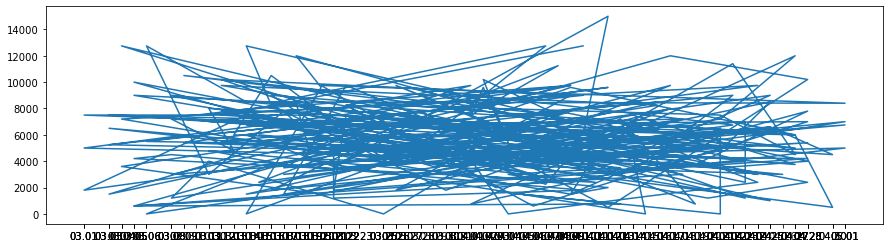

In [18]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))
ax.plot(xx, yy)
ax.xaxis.set_ticks(xx)

plt.show()

*Намеков на зависимость таргета от даты нет, поэтому оставим total_points, application и coef, а также подберем доп.множитель*

In [19]:
data['new'] = data['coef'] * data['total_points'] * data['application']
X = data[['new']]

y = data['increase']

model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.coef_)

1.0
[500.]
